In [501]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [502]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40475 entries, 0 to 40474
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     40475 non-null  object 
 1   description               40475 non-null  object 
 2   summary                   40463 non-null  object 
 3   installs                  40475 non-null  object 
 4   minInstalls               40475 non-null  float64
 5   score                     40475 non-null  float64
 6   ratings                   40475 non-null  float64
 7   reviews                   40475 non-null  float64
 8   histogram                 40475 non-null  object 
 9   price                     40475 non-null  float64
 10  free                      40475 non-null  int64  
 11  currency                  40475 non-null  object 
 12  sale                      40475 non-null  bool   
 13  offersIAP                 40475 non-null  bool   
 14  inAppP

In [503]:
df[df['title'] == '#SelfCare']

,title,description,summary,installs,minInstalls,score,ratings,reviews,histogram,price,...,star_2,star_3,star_4,star_5,top_developer,current_date,days,installs_day,updated_days,has_video
265,#SelfCare,Hello. This is us! We're staying home for the ...,Let's stay in bed all day. <3,"500,000+",500000.0,4.510254,12123.0,3876.0,"[557, 338, 656, 1382, 9190]",0.0,...,338,656,1382,9190,0,2021-03-04,906,551.87638,583,0


In [504]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [505]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [506]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [507]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,test_size=.20, random_state=10)

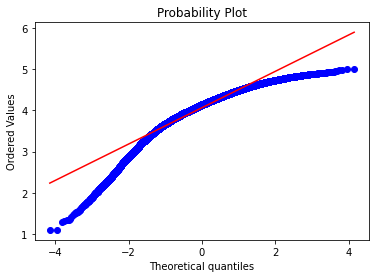

In [508]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

## Testing with pipeline

In [509]:
## Define pipeline transformers 

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',sparse='false'))])

In [510]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [511]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear', LinearRegression())])

In [512]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse='false'))]),
                                                  Index(['genre', 'contentRating'], dtype='object'))])),
                ('linear', LinearRegression())])

In [513]:
y_pred = lr.predict(X_val)

In [514]:
lr.score(X_val,y_val)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.36


In [515]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val.columns, lr['linear'].coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.09
free : -0.01
containsAds : -0.00
genre : 0.00
editorsChoice : -0.01
contentRating : 0.07
year : -0.00
top_developer : -0.02
installs_day : 0.02
updated_days : 0.23
has_video : -0.11
compound : 0.01


## No pipeline

In [516]:
X_train_cont = X_train[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont = X_val[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [517]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[['genre','contentRating']])

ohe_x_train = ohe.transform(X_train[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_train_df = pd.DataFrame(ohe_x_train, columns=columns, index=X_train.index)

In [518]:
ohe_v = OneHotEncoder(drop='first', sparse=False)

ohe_v.fit(X_val[['genre','contentRating']])

ohe_x_val = ohe_v.transform(X_val[['genre','contentRating']])

columns_v = ohe_v.get_feature_names(['genre','contentRating'])

ohe_x_val_df = pd.DataFrame(ohe_x_val, columns=columns_v, index=X_val.index)

In [519]:
#Merge cont and cat DFs
combo_train_df = pd.concat([X_train_cont, ohe_x_train_df], axis=1)

combo_val_df =  pd.concat([X_val_cont, ohe_x_val_df], axis=1)

In [520]:
lr = LinearRegression()

lr.fit(combo_train_df, y_train)

y_pred = lr.predict(combo_val_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(combo_val_df, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.34
MSE of linear regression on val set: 0.37


In [521]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df.columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.16
year : -0.01
top_developer : 0.47
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.25
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.08
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.20
genre_Board : 0.08
genre_Books & Reference : 0.16
genre_Business : 0.15
genre_Card : 0.19
genre_Casino : 0.25
genre_Casual : -0.03
genre_Comics : -0.10
genre_Communication : 0.07
genre_Dating : -0.04
genre_Education : 0.01
genre_Entertainment : -0.06
genre_Events : -0.06
genre_Finance : 0.18
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.08
genre_Libraries & Demo : -0.04
genre_Lifestyle : 0.01
genre_Maps & Navigation : 0.09
genre_Medical : 0.05
genre_Music : -0.04
genre_Music & Audio : 0.06
genre_News & Magazines : 0.05
genre_Parenting : 0.09
genre_Personalization : 0.08
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.12
genr

In [522]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(combo_val_df)
check['resid'] = check['pred'] - check['score']

In [523]:
check.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
29886,14745.0,1,0,Finance,0,Everyone,2015,0,514.933059,1,1,-0.006365,1.519715,3.961361,2.441646
4725,8652.0,1,1,Books & Reference,0,Teen,2014,0,204.081633,1857,0,0.114956,1.795376,3.908748,2.113372
30260,41646.0,1,0,Education,0,Everyone,2014,0,419.815281,51,1,-0.048156,1.696547,3.740291,2.043744
6837,8768.0,1,0,Dating,0,Mature 17+,2013,0,375.657400,7,1,-0.071501,1.768969,3.688608,1.919638
30046,25281.0,1,0,Tools,0,Everyone,2013,0,354.609929,41,0,-0.001986,1.873423,3.791739,1.918317
16828,4617.0,1,1,Entertainment,0,Everyone,2015,0,235.515780,1224,0,-0.155334,1.575693,3.380631,1.804938
2434,22315.0,1,1,Lifestyle,0,Everyone,2010,0,266.311585,75,0,0.106293,2.106250,3.899991,1.793741
16617,4263.0,1,0,Tools,0,Everyone,2016,0,307.125307,147,0,-0.083349,1.870670,3.653624,1.782954
13275,31591.0,1,1,Books & Reference,0,Mature 17+,2018,0,1245.330012,33,0,0.484041,2.700556,4.462689,1.762133
4836,1237.0,1,1,Tools,0,Everyone,2013,0,178.826896,645,1,-0.039856,2.024390,3.765274,1.740884


In [524]:
check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
8435,7904.0,1,1,Entertainment,0,Everyone,2015,0,247.279921,251,0,0.252837,3.892541,3.943488,0.050947
18251,1760.0,1,1,Puzzle,0,Everyone,2017,0,407.830343,836,0,0.338667,4.204546,4.185071,-0.019474
6702,1420.0,1,1,Board,0,Everyone,2017,0,344.115623,679,0,0.122654,3.809859,3.882247,0.072388
7306,7254.0,1,1,Simulation,0,Everyone,2017,0,732.600733,488,0,-0.055390,3.488276,3.505656,0.017380
24858,6342.0,1,1,Racing,0,Everyone,2018,0,977.517107,606,1,0.502224,4.227554,4.324468,0.096914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,11017.0,1,1,Education,0,Everyone,2013,0,357.653791,862,1,0.214696,4.005410,4.023092,0.017682
28243,1151.0,1,1,Simulation,0,Everyone,2019,0,800.000000,235,0,-0.142317,3.394958,3.390659,-0.004299
13426,5694.0,1,0,Communication,0,Everyone,2017,0,415.627598,77,0,0.047746,3.873905,3.825108,-0.048798
14350,1474.0,1,1,Music & Audio,0,Everyone,2016,0,303.030303,160,0,0.557009,4.360544,4.440722,0.080178


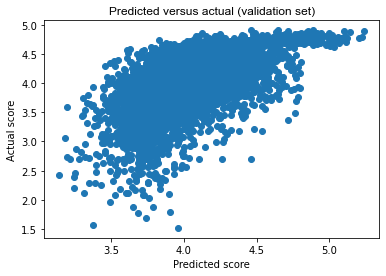

In [525]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

Specifically, way over predicting the lower scoring apps - typically earleir years

## Testing with apps below 2.5 score dropped

In [526]:
df_copy = df.copy()
df_copy = df_copy[df_copy['score'] >= 2.5]

In [527]:
X2 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video','compound']]

y2 = df_copy['score']

In [528]:
# Split to create temporary tr and test 
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(X2, y2,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_tr2, y_tr2,test_size=.20, random_state=10)

In [529]:
X_train_cont2 = X_train2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont2 = X_val2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [530]:
ohe2 = OneHotEncoder(drop='first', sparse=False)

ohe2.fit(X_train2[['genre','contentRating']])

ohe_x_train2 = ohe2.transform(X_train2[['genre','contentRating']])

columns2 = ohe2.get_feature_names(['genre','contentRating'])

ohe_x_train_df2 = pd.DataFrame(ohe_x_train2, columns=columns2, index=X_train2.index)

In [531]:
ohe_v2 = OneHotEncoder(drop='first', sparse=False)

ohe_v2.fit(X_val2[['genre','contentRating']])

ohe_x_val2 = ohe_v2.transform(X_val2[['genre','contentRating']])

columns_v2 = ohe_v2.get_feature_names(['genre','contentRating'])

ohe_x_val_df2 = pd.DataFrame(ohe_x_val2, columns=columns_v2, index=X_val2.index)

In [532]:
#Merge cont and cat DFs
combo_train_df2 = pd.concat([X_train_cont2, ohe_x_train_df2], axis=1)

combo_val_df2 =  pd.concat([X_val_cont2, ohe_x_val_df2], axis=1)

In [533]:
lr2 = LinearRegression()

lr2.fit(combo_train_df2, y_train2)

y_pred2 = lr2.predict(combo_val_df2)
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(combo_val_df2, y_val2)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val2, y_pred2))))

R^2 of linear regression on val set: 0.33
MSE of linear regression on val set: 0.34


In [534]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df2.columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.14
containsAds : -0.02
editorsChoice : 0.14
year : -0.01
top_developer : 0.47
installs_day : 0.00
updated_days : -0.00
has_video : 0.06
compound : 1.12
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.05
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.10
genre_Board : 0.08
genre_Books & Reference : 0.18
genre_Business : 0.13
genre_Card : 0.20
genre_Casino : 0.27
genre_Casual : -0.04
genre_Comics : -0.12
genre_Communication : 0.08
genre_Dating : -0.09
genre_Education : 0.01
genre_Entertainment : -0.04
genre_Events : -0.01
genre_Finance : 0.18
genre_Food & Drink : 0.16
genre_Health & Fitness : 0.14
genre_House & Home : 0.04
genre_Libraries & Demo : 0.11
genre_Lifestyle : 0.06
genre_Maps & Navigation : 0.12
genre_Medical : 0.12
genre_Music : -0.05
genre_Music & Audio : 0.08
genre_News & Magazines : 0.10
genre_Parenting : 0.10
genre_Personalization : 0.09
genre_Photography : -0.06
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre

In [535]:
check2 = X_val2.copy()
check2['score'] = y_val2
check2['pred'] = lr2.predict(combo_val_df2)
check2['resid'] = check2['pred'] - check2['score']

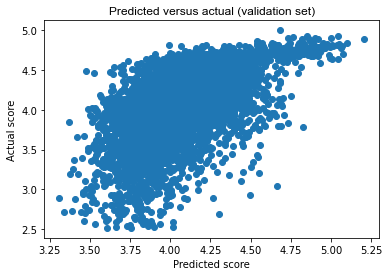

In [536]:
fig, ax = plt.subplots()
plt.scatter(y_pred2,y_val2)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

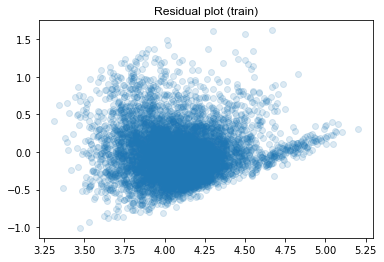

In [537]:
plt.scatter(check2['pred'],check2['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);

In [538]:
small_cluster_df = check2[check2['pred'] >= 4.5]

In [539]:
check2.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,compound,score,pred,resid
top_developer,,,,,,,,,,,,,,
0,6225,6225,6225,6225,6225,6225,6225,6225,6225,6225,6225,6225,6225,6225
1,192,192,192,192,192,192,192,192,192,192,192,192,192,192


In [540]:
small_cluster_df.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,compound,score,pred,resid
top_developer,,,,,,,,,,,,,,
0,137,137,137,137,137,137,137,137,137,137,137,137,137,137
1,179,179,179,179,179,179,179,179,179,179,179,179,179,179


In [541]:
check2.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
13099,2529.0,1,1,Sports,0,Everyone 10+,2018,0,570.125428,439,0,0.821018,3.043307,4.666274,1.622967
7628,8852.0,1,0,Productivity,0,Everyone,2016,0,634.115409,477,0,0.453815,2.685876,4.303692,1.617816
38260,1108.0,1,1,Health & Fitness,0,Everyone,2018,0,554.323725,353,0,0.584426,2.928571,4.496768,1.568197
20114,6184.0,1,0,Food & Drink,0,Mature 17+,2017,0,752.445448,79,0,0.103731,2.524039,4.015535,1.491496
39820,6210.0,1,0,Entertainment,0,Teen,2017,0,399.042298,86,1,0.244322,2.594203,4.018478,1.424275
23795,7000.0,1,1,Shopping,0,Everyone,2011,0,137.551582,36,1,0.244435,2.890000,4.268016,1.378016
15243,4022.0,1,1,Books & Reference,0,Everyone,2016,0,592.066311,1688,0,0.101257,2.559406,3.935010,1.375604
40343,2303.0,1,0,Shopping,0,Everyone,2014,0,213.675214,50,0,-0.023840,2.526087,3.897471,1.371384
16347,2104.0,1,1,Casual,0,Everyone,2020,0,2293.577982,159,1,0.731393,3.206573,4.549682,1.343109
14378,1210.0,1,1,Lifestyle,0,Mature 17+,2017,0,776.397516,27,0,0.580285,3.106557,4.436818,1.330261


## Breaking out group

In [542]:
df_analysis = check2[check2['pred'] < 4.5]

In [543]:
df_analysis

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
20933,12150.0,1,1,Arcade,0,Teen,2019,0,759.878419,9,1,0.203616,3.734979,4.012751,0.277772
35546,9238.0,1,1,Action,0,Everyone 10+,2016,0,284.575982,1489,1,0.142990,4.220726,3.903743,-0.316982
12472,2311.0,1,1,Education,0,Everyone,2014,0,394.166338,226,1,0.392600,3.913420,4.256182,0.342762
37200,4387.0,1,1,Tools,0,Everyone,2020,0,2577.319588,3,0,0.310871,4.054945,4.128525,0.073580
13657,19622.0,1,1,Casual,0,Everyone,2015,0,453.103761,245,0,0.285902,4.114837,4.015635,-0.099202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39568,3213.0,1,1,Adventure,0,Mature 17+,2019,0,1543.209877,40,0,0.656083,4.203540,4.350224,0.146684
13021,5430.0,1,1,Personalization,0,Everyone,2014,0,196.078431,334,0,0.154057,3.996324,3.999042,0.002718
40259,6483.0,1,1,Education,0,Everyone,2013,0,374.391614,773,1,0.347815,4.218126,4.181690,-0.036436
32936,21224.0,1,1,Simulation,0,Teen,2016,0,539.083558,226,1,0.240717,4.217719,3.955091,-0.262628


## Testing with specific columns for genre - all apps

In [544]:
df_3 = df.copy()

In [547]:
df_3['action'] = np.where(df_3['genre'] == 'Action',1,0)
df_3['book_ref'] = np.where(df_3['genre'] == 'Books & Reference',1,0)
df_3['business'] = np.where(df_3['genre'] == 'Business',1,0)
df_3['card'] = np.where(df_3['genre'] == 'Card',1,0)
df_3['casino'] = np.where(df_3['genre'] == 'Casino',1,0)
df_3['comics'] = np.where(df_3['genre'] == 'Comics',1,0)
df_3['dating'] = np.where(df_3['genre'] == 'Dating',1,0)
df_3['education'] = np.where(df_3['genre'] == 'Education',1,0)
df_3['finance'] = np.where(df_3['genre'] == 'Finance',1,0)
df_3['food_drink'] = np.where(df_3['genre'] == 'Food & Drink',1,0)
df_3['health_fit'] = np.where(df_3['genre'] == 'Health & Fitness',1,0)
df_3['lib_demo'] = np.where(df_3['genre'] == 'Libraries & Demo',1,0)
df_3['puzzle'] = np.where(df_3['genre'] == 'Puzzle',1,0)
df_3['simulation'] = np.where(df_3['genre'] == 'Simulation',1,0)
df_3['weather'] = np.where(df_3['genre'] == 'Weather',1,0)
df_3['word'] = np.where(df_3['genre'] == 'Word',1,0)
df_3['vid_edit'] = np.where(df_3['genre'] == 'Video Players & Editors',1,0)

In [548]:
X3 = df_3[['ratings','free','containsAds','editorsChoice','contentRating','year','top_developer','installs_day',
           'updated_days','has_video','compound',
          'action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

y3 = df_3['score']

In [551]:
# Split to create temporary tr and test 
X_tr3, X_test3, y_tr3, y_test3 = train_test_split(X3, y3,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_tr3, y_tr3,test_size=.20, random_state=10)

In [552]:
X_train_cont3 = X_train3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'compound','action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

X_val_cont3 = X_val3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'compound','action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

In [553]:
ohe3 = OneHotEncoder(drop='first', sparse=False)

ohe3.fit(X_train3[['contentRating']])

ohe_x_train3 = ohe3.transform(X_train3[['contentRating']])

columns3 = ohe3.get_feature_names(['contentRating'])

ohe_x_train_df3 = pd.DataFrame(ohe_x_train3, columns=columns3, index=X_train3.index)

In [554]:
ohe_v3 = OneHotEncoder(drop='first', sparse=False)

ohe_v3.fit(X_val3[['contentRating']])

ohe_x_val3 = ohe_v3.transform(X_val3[['contentRating']])

columns_v3 = ohe_v3.get_feature_names(['contentRating'])

ohe_x_val_df3 = pd.DataFrame(ohe_x_val3, columns=columns_v3, index=X_val3.index)

In [555]:
#Merge cont and cat DFs
combo_train_df3 = pd.concat([X_train_cont3, ohe_x_train_df3], axis=1)

combo_val_df3 =  pd.concat([X_val_cont3, ohe_x_val_df3], axis=1)

In [556]:
combo_val_df3

,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,action,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen
10985,1,1,0,2016,0,584.795322,35,1,0.510733,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
39902,1,0,0,2015,0,232.774674,629,0,0.280533,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
15793,1,1,0,2015,0,246.791708,2018,0,0.149738,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
8435,1,1,0,2015,0,247.279921,251,0,0.252837,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
14863,1,1,0,2016,0,598.086124,521,0,0.509831,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35732,1,1,0,2019,0,744.047619,610,0,0.267129,0,...,0,0,0,1,0,0,0,0.0,0.0,0.0
20731,1,1,0,2016,0,620.347395,1442,1,0.368571,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
5111,1,1,0,2015,0,500.500501,6,0,0.181144,0,...,0,0,1,0,0,0,0,0.0,0.0,0.0
27268,1,1,0,2018,0,1075.268817,86,0,0.461963,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


In [557]:
lr3 = LinearRegression()

lr3.fit(combo_train_df3, y_train3)

y_pred3 = lr3.predict(combo_val_df3)
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(combo_val_df3, y_val3)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val3, y_pred3))))

R^2 of linear regression on val set: 0.33
MSE of linear regression on val set: 0.37


In [558]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df3.columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.11
containsAds : -0.03
editorsChoice : 0.15
year : -0.01
top_developer : 0.48
installs_day : 0.00
updated_days : -0.00
has_video : 0.06
compound : 1.24
action : 0.00
book_ref : 0.15
business : 0.12
card : 0.18
casino : 0.25
comics : -0.10
dating : -0.06
education : -0.01
finance : 0.15
food_drink : 0.10
health_fit : 0.10
lib_demo : -0.06
puzzle : 0.11
simulation : -0.09
weather : 0.03
word : 0.20
vid_edit : -0.07
contentRating_Everyone 10+ : 0.03
contentRating_Mature 17+ : 0.01
contentRating_Teen : -0.03


In [559]:
check3 = X_val3.copy()
check3['score'] = y_val3
check3['pred'] = lr3.predict(combo_val_df3)
check3['resid'] = check3['pred'] - check3['score']

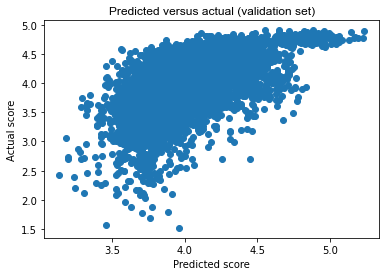

In [560]:
fig, ax = plt.subplots()
plt.scatter(y_pred3,y_val3)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

In [561]:
check3.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,score,pred,resid
29886,14745.0,1,0,0,Everyone,2015,0,514.933059,1,1,...,0,0,0,0,0,0,0,1.519715,3.963517,2.443801
4725,8652.0,1,1,0,Teen,2014,0,204.081633,1857,0,...,0,0,0,0,0,0,0,1.795376,3.885390,2.090014
30260,41646.0,1,0,0,Everyone,2014,0,419.815281,51,1,...,0,0,0,0,0,0,0,1.696547,3.760759,2.064212
6837,8768.0,1,0,0,Mature 17+,2013,0,375.657400,7,1,...,0,0,0,0,0,0,0,1.768969,3.708140,1.939170
30046,25281.0,1,0,0,Everyone,2013,0,354.609929,41,0,...,0,0,0,0,0,0,0,1.873423,3.775921,1.902498
16828,4617.0,1,1,0,Everyone,2015,0,235.515780,1224,0,...,0,0,0,0,0,0,0,1.575693,3.457458,1.881765
2434,22315.0,1,1,0,Everyone,2010,0,266.311585,75,0,...,0,0,0,0,0,0,0,2.106250,3.915014,1.808764
16617,4263.0,1,0,0,Everyone,2016,0,307.125307,147,0,...,0,0,0,0,0,0,0,1.870670,3.630209,1.759540
13275,31591.0,1,1,0,Mature 17+,2018,0,1245.330012,33,0,...,0,0,0,0,0,0,0,2.700556,4.448997,1.748441
4836,1237.0,1,1,0,Everyone,2013,0,178.826896,645,1,...,0,0,0,0,0,0,0,2.024390,3.724116,1.699726


## with transformed target

In [562]:
from scipy.stats import boxcox

In [564]:
X4 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video','compound']]

bcx_target,lam =boxcox(df_copy['score'])

In [565]:
len(bcx_target)

40103

In [566]:
# Split to create temporary tr and test 
X_tr4, X_test4, y_tr4, y_test4 = train_test_split(X4, bcx_target,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_tr4, y_tr4,test_size=.20, random_state=10)

In [567]:
X_train_cont4 = X_train4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]
X_val_cont4 = X_val4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video','compound']]

In [568]:
ohe4 = OneHotEncoder(drop='first', sparse=False)

ohe4.fit(X_train4[['genre','contentRating']])

ohe_x_train4 = ohe4.transform(X_train4[['genre','contentRating']])

columns4 = ohe4.get_feature_names(['genre','contentRating'])

ohe_x_train_df4 = pd.DataFrame(ohe_x_train4, columns=columns4, index=X_train4.index)

In [569]:
ohe_v4 = OneHotEncoder(drop='first', sparse=False)

ohe_v4.fit(X_val4[['genre','contentRating']])

ohe_x_val4 = ohe_v4.transform(X_val4[['genre','contentRating']])

columns_v4 = ohe_v4.get_feature_names(['genre','contentRating'])

ohe_x_val_df4 = pd.DataFrame(ohe_x_val4, columns=columns_v4, index=X_val4.index)

In [570]:
#Merge cont and cat DFs
combo_train_df4 = pd.concat([X_train_cont4, ohe_x_train_df4], axis=1)

combo_val_df4 =  pd.concat([X_val_cont4, ohe_x_val_df4], axis=1)

In [571]:
lr4 = LinearRegression()

lr4.fit(combo_train_df4, y_train4)

y_pred4 = lr4.predict(combo_val_df4)
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(combo_val_df4, y_val4)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val4, y_pred4))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 13.75


In [572]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df4.columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -7.04
containsAds : -1.00
editorsChoice : 6.56
year : -0.33
top_developer : 26.54
installs_day : 0.00
updated_days : -0.00
has_video : 2.43
compound : 44.83
genre_Adventure : -3.34
genre_Arcade : 1.39
genre_Art & Design : -1.00
genre_Auto & Vehicles : 4.87
genre_Beauty : -3.32
genre_Board : 4.04
genre_Books & Reference : 9.41
genre_Business : 6.43
genre_Card : 9.08
genre_Casino : 13.07
genre_Casual : -1.07
genre_Comics : -3.75
genre_Communication : 4.02
genre_Dating : -2.65
genre_Education : 1.41
genre_Entertainment : -1.08
genre_Events : 0.97
genre_Finance : 8.94
genre_Food & Drink : 7.95
genre_Health & Fitness : 7.69
genre_House & Home : 2.38
genre_Libraries & Demo : 4.89
genre_Lifestyle : 3.89
genre_Maps & Navigation : 6.22
genre_Medical : 6.57
genre_Music : -1.64
genre_Music & Audio : 4.47
genre_News & Magazines : 5.12
genre_Parenting : 4.73
genre_Personalization : 4.95
genre_Photography : -1.31
genre_Productivity : 3.91
genre_Puzzle : 6.15
gen

In [573]:
check4 = X_val4.copy()
check4['score'] = y_val4
check4['pred'] = lr4.predict(combo_val_df4)
check4['resid'] = check4['pred'] - check4['score']

In [574]:
check4.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
13099,2529.0,1,1,Sports,0,Everyone 10+,2018,0,570.125428,439,0,0.821018,16.383119,74.482416,58.099297
38260,1108.0,1,1,Health & Fitness,0,Everyone,2018,0,554.323725,353,0,0.584426,14.173841,69.116789,54.942948
7628,8852.0,1,0,Productivity,0,Everyone,2016,0,634.115409,477,0,0.453815,10.214280,60.821554,50.607274
16347,2104.0,1,1,Casual,0,Everyone,2020,0,2293.577982,159,1,0.731393,19.939245,69.569033,49.629788
14378,1210.0,1,1,Lifestyle,0,Mature 17+,2017,0,776.397516,27,0,0.580285,17.701410,66.396612,48.695202
7441,2973.0,1,1,Tools,0,Everyone,2018,0,1043.841336,20,0,0.593662,20.131127,66.577067,46.445940
6531,1675.0,1,1,Simulation,0,Everyone,2018,0,454.132607,196,0,0.782256,21.742597,67.587994,45.845397
23795,7000.0,1,1,Shopping,0,Everyone,2011,0,137.551582,36,1,0.244435,13.481731,59.098809,45.617078
25844,4643.0,1,1,Travel & Local,0,Everyone,2018,0,1180.637544,503,1,0.632746,23.452345,68.887447,45.435102
900,10825.0,1,1,Food & Drink,0,Teen,2017,0,736.377025,134,0,0.855825,37.164776,81.935696,44.770921


In [575]:
check4[(check4['resid'] >= -0.1) & (check4['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,compound,score,pred,resid
15849,56168.0,1,0,Casual,0,Everyone 10+,2012,0,1535.155051,1023,0,0.533717,60.928184,61.017594,0.089410
4542,5194.0,1,1,Racing,0,Everyone,2018,0,521.920668,709,1,0.305976,49.578733,49.613649,0.034915
32298,9370.0,1,1,Card,0,Teen,2016,0,635.324015,23,1,0.264503,59.540621,59.603158,0.062537
22949,3932.0,1,0,Communication,0,Mature 17+,2019,0,1282.051282,771,0,0.461458,59.612569,59.616766,0.004198
33716,22127.0,1,1,Photography,0,Everyone,2016,1,621.118012,354,0,0.346923,76.760124,76.677379,-0.082745
33713,4905.0,1,1,Art & Design,0,Everyone,2019,0,1428.571429,649,0,0.435418,52.723105,52.779034,0.055929
29845,10524.0,1,1,Personalization,0,Everyone,2014,0,199.282583,1912,1,0.306730,53.290084,53.383512,0.093428
31593,26163.0,1,1,Casino,0,Teen,2014,0,191.570881,1119,0,0.269481,59.050034,58.984486,-0.065548
33302,15603.0,1,1,Racing,0,Everyone,2019,0,20242.914980,0,0,0.282713,51.449856,51.441341,-0.008514
3500,77005.0,1,1,Action,0,Teen,2018,0,6281.407035,617,1,0.079873,41.091593,41.037661,-0.053932


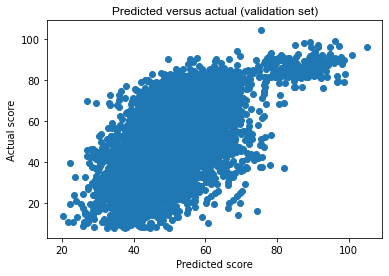

In [576]:
fig, ax = plt.subplots()
plt.scatter(y_pred4,y_val4)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

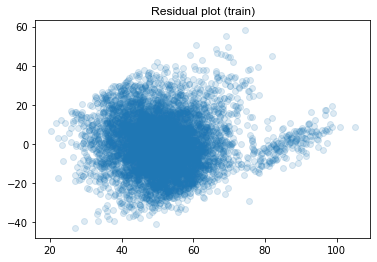

In [577]:
plt.scatter(check4['pred'],check4['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);